# Module 2 - Exam - Part 2 - Practical

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/1/18/Bayes%27_Theorem_MMB_01.jpg" width="400px" height="300px" />

> In the second part of the exam, you will program you will set up a learning scheme for a Bayesian network based on approximate inference (sampling methods).
>
> We learned how to approximately infer distributions and conditional distributions from samples. The idea is to use that to learn the parameters (CPDs) of a Bayesian network from the data, and then use the model for predicting new data instances labels.
>
> Good luck!

> **References:**
> 
> - Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 
    - https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29


<p style="text-align:right;"> Imagen recuperada de: https://upload.wikimedia.org/wikipedia/commons/1/18/Bayes%27_Theorem_MMB_01.jpg.</p>

___

# Approximate-inference-based learning (50 points).

The directory `data` contains two files:
 - `breast-cancer-wisconsin.data`
 - `breast-cancer-wisconsin.names`
 
which correspond to a breast cancer database, which was obtained from the University of Wisconsin Hospitals, Madison from Dr. William H. Wolberg.

It contains 699 instances, each one with 9 features (attributes) and the class it belongs to (benign or malignant).


  |   | Attribute                   | Domain    |
  |-- |-----------------------------|-----------|
  |1. | Sample code number          | id number |
  |2. | Clump Thickness             | 1 - 10    |
  |3. | Uniformity of Cell Size     | 1 - 10    |
  |4. | Uniformity of Cell Shape    | 1 - 10    |
  |5. | Marginal Adhesion           | 1 - 10    |
  |6. | Single Epithelial Cell Size | 1 - 10    |
  |7. | Bare Nuclei                 | 1 - 10    |
  |8. | Bland Chromatin             | 1 - 10    |
  |9. | Normal Nucleoli             | 1 - 10    |
  |10.| Mitoses                     | 1 - 10    |
  |11.| Class:                      | (2 for benign, 4 for malignant)|
  
Please, read the `breast-cancer-wisconsin.names` for more information.

## 1. EDA (10 points)

Perform some exploratory data analysis over the fruits dataset to get familiarized with the data.

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
import plotly.express as px
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
headers = ['id', 'clump', 'cell_size', 'cell_shape', 'adhesion', 'epithelial', 'nuclei', 'chromatin', 'normal','mitoses', 'category']
df = pd.read_csv('C:/Users/Omar/Documents/Modelos Graficos Probabilisticos/mgpo2020/Modulo3/data/breast-cancer-wisconsin.data', 
                names = headers,  na_values='?')
df = df.fillna(0)
df.head()

id  clump  cell_size  cell_shape  adhesion  epithelial  nuclei  \
0  1000025      5          1           1         1           2     1.0   
1  1002945      5          4           4         5           7    10.0   
2  1015425      3          1           1         1           2     2.0   
3  1016277      6          8           8         1           3     4.0   
4  1017023      4          1           1         3           2     1.0   

   chromatin  normal  mitoses  category  
0          3       1        1         2  
1          3       2        1         2  
2          3       1        1         2  
3          3       7        1         2  
4          3       1        1         2

In [3]:
df.nuclei = df.nuclei.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id          699 non-null    int64
 1   clump       699 non-null    int64
 2   cell_size   699 non-null    int64
 3   cell_shape  699 non-null    int64
 4   adhesion    699 non-null    int64
 5   epithelial  699 non-null    int64
 6   nuclei      699 non-null    int32
 7   chromatin   699 non-null    int64
 8   normal      699 non-null    int64
 9   mitoses     699 non-null    int64
 10  category    699 non-null    int64
dtypes: int32(1), int64(10)
memory usage: 57.5 KB


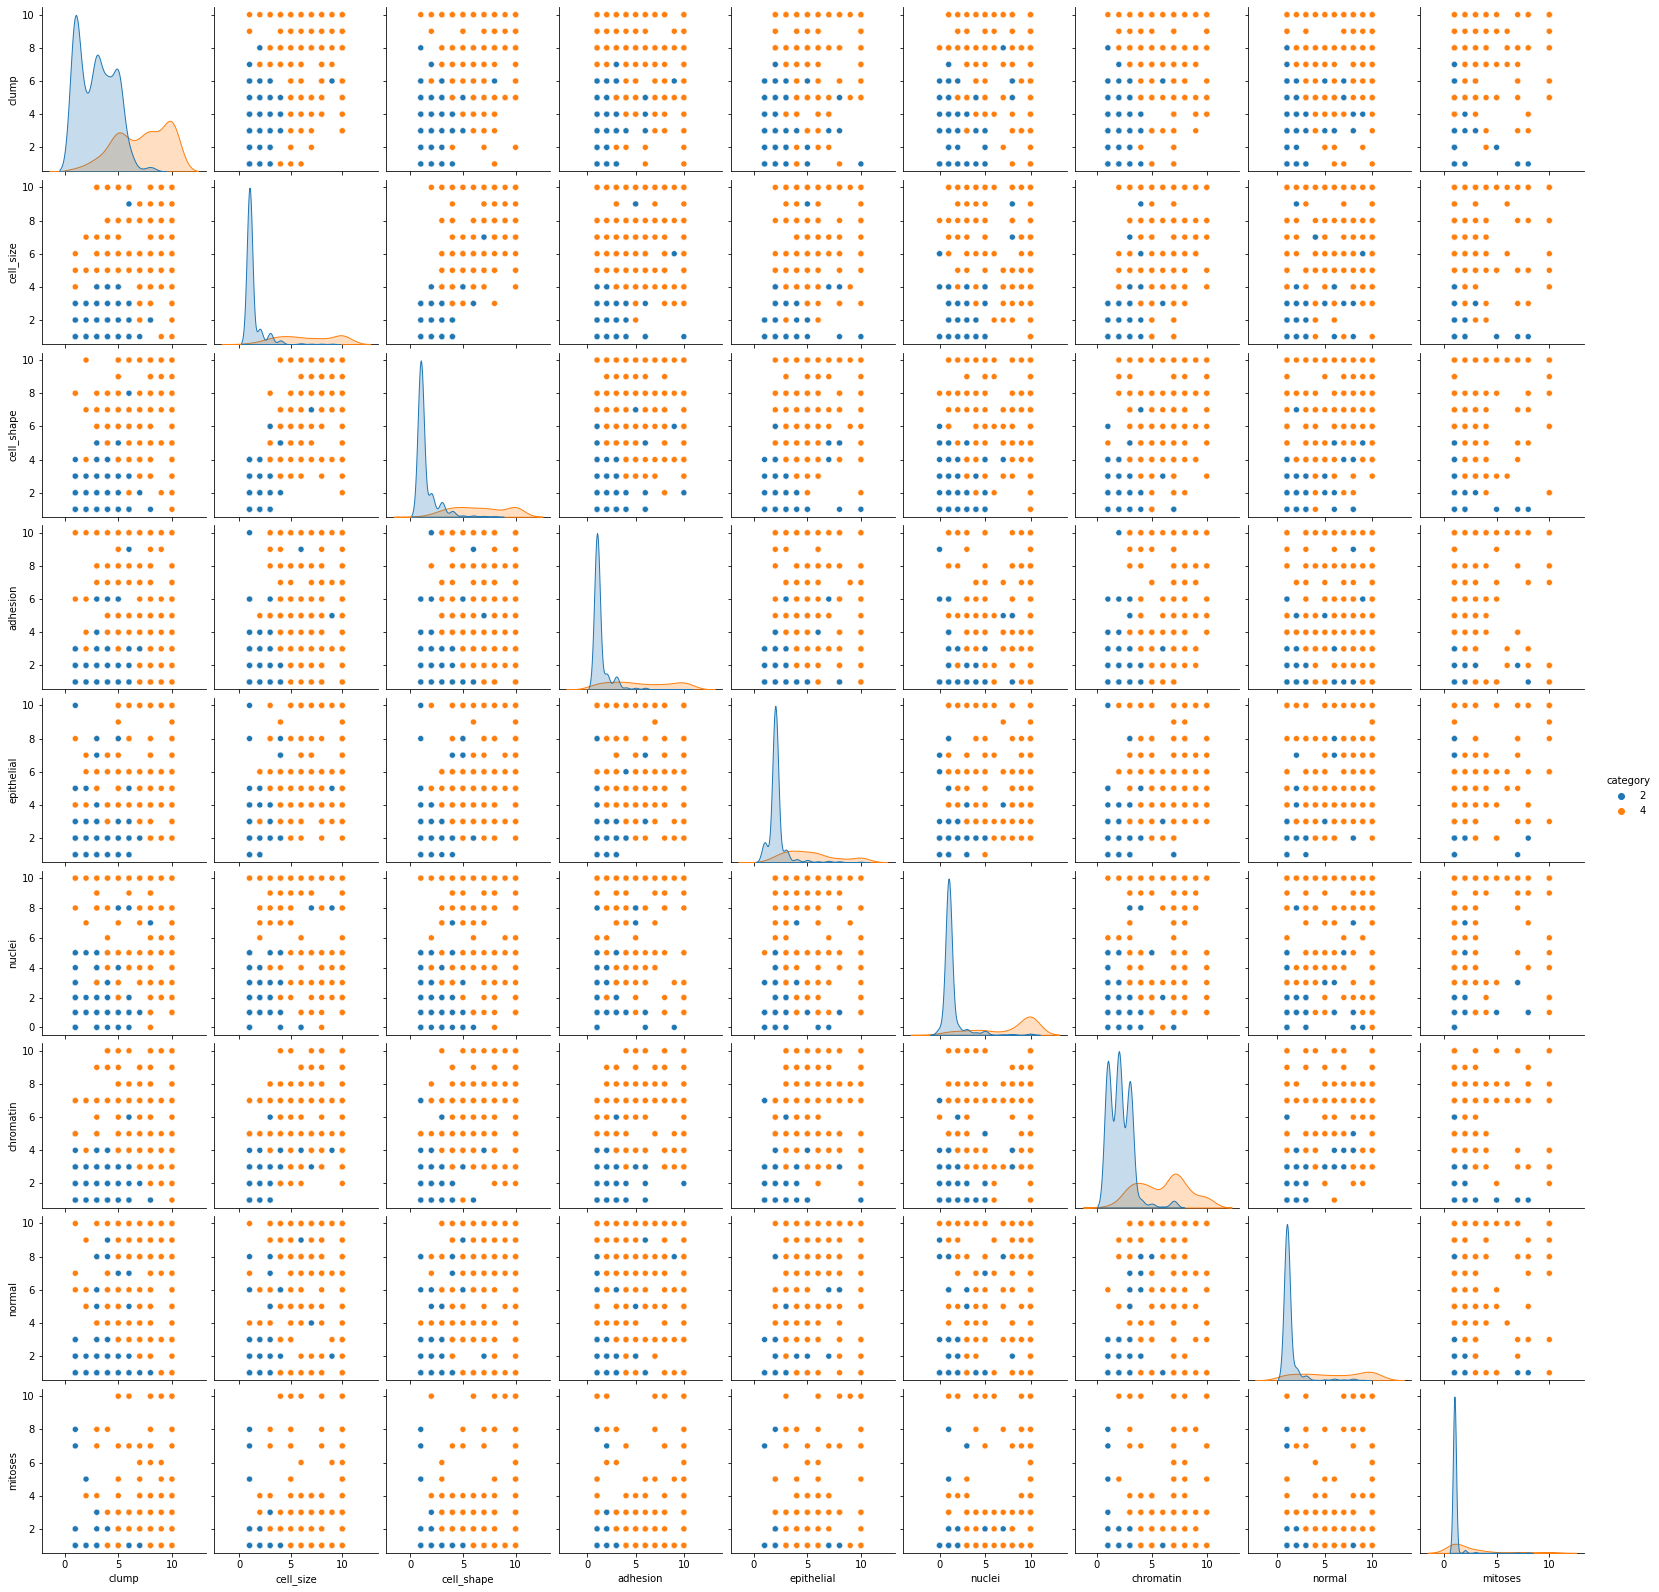

In [57]:
df.category = df.category.astype('category')
sns.pairplot(df.iloc[:,1:], hue = 'category')

In [58]:
df.iloc[:,1:-1].corr()

clump  cell_size  cell_shape  adhesion  epithelial    nuclei  \
clump       1.000000   0.644913    0.654589  0.486356    0.521816  0.589296   
cell_size   0.644913   1.000000    0.906882  0.705582    0.751799  0.684569   
cell_shape  0.654589   0.906882    1.000000  0.683079    0.719668  0.704529   
adhesion    0.486356   0.705582    0.683079  1.000000    0.599599  0.665723   
epithelial  0.521816   0.751799    0.719668  0.599599    1.000000  0.582904   
nuclei      0.589296   0.684569    0.704529  0.665723    0.582904  1.000000   
chromatin   0.558428   0.755721    0.735948  0.666715    0.616102  0.671545   
normal      0.535835   0.722865    0.719446  0.603352    0.628881  0.572054   
mitoses     0.350034   0.458693    0.438911  0.417633    0.479101  0.342795   

            chromatin    normal   mitoses  
clump        0.558428  0.535835  0.350034  
cell_size    0.755721  0.722865  0.458693  
cell_shape   0.735948  0.719446  0.438911  
adhesion     0.666715  0.603352  0.417633  
epithelial   0.616102  0.628881  0.479101  
nuclei       0.671545  0.572054  0.342795  
chromatin    1.000000  0.665878  0.344169  
normal       0.665878  1.000000  0.428336  
mitoses      0.344169  0.428336  1.000000

In [75]:
px.histogram(df, x="category", color="category", marginal="rug", # can be `box`, `violin`
                         hover_data=df.columns)

In [4]:
df.category = df.category.astype(int)
for col in df: 
    df[col] = pd.cut(df[col], bins=2, labels= [0,1])

In [5]:
df.head()

id clump cell_size cell_shape adhesion epithelial nuclei chromatin normal  \
0  0     0         0          0        0          0      0         0      0   
1  0     0         0          0        0          1      1         0      0   
2  0     0         0          0        0          0      0         0      0   
3  0     1         1          1        0          0      0         0      1   
4  0     0         0          0        0          0      0         0      0   

  mitoses category  
0       0        0  
1       0        0  
2       0        0  
3       0        0  
4       0        0

## 2. Design Bayesian network (30 points)

2.1. Design a Bayesian network that capture the relationships between the variables in the data. 

- The simplest choice would be a Naïve Bayes model, but if you propose a model taking into account some relationships that you may find in the literature (**include reference in this case**), it will be widely considered for your grade.

2.2. Split the dataset into train and test. Be sure to suffle the data.

2.3. For the Bayesian network you designed in the last point, estimate the CPDs using the samples in `breast-cancer-wisconsin.data`. For this point, use the methodology that we used in section 1.2 - Clase 9 (Forward sampling in Bayesian networks).

- According to the number of data instances, what is the error in your estimation?, With what confidence?

**You are not allowed to use the `.fit` method**

2.4. For the test data instances, obtain the accuracy the MAP classifier using the Bayesian network.

## 2.1

In [6]:
# Import pgmpy.factors.discrete.TabularCPD
from pgmpy.factors.discrete import TabularCPD
# Import pgmpy.models.BayesianModel
from pgmpy.models import BayesianModel

In [7]:
model = BayesianModel([('cell_shape','clump'),
                       ('cell_size','clump'),
                       ('cell_size','epithelial'),
                       ('epithelial','clump'),
                       ('clump','category'),
                       ('adhesion','category'),
                       ('nuclei','category'),
                       ('chromatin','category'),
                       ('normal','category'),
                       ('mitoses','category')])

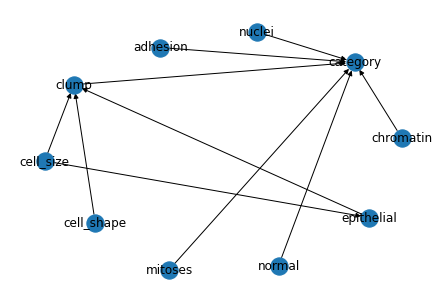

In [8]:
nx.draw(model, with_labels=True)

**Nuestra red está construida basada en un articulo que leimos donde se analizaron variables similares a las de nuestro proyecto.** [Referencia al artículo](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjJ3Nuvl_HsAhUJTawKHZPDCkoQFjADegQIBhAC&url=http%3A%2F%2Fijarcs.info%2Findex.php%2FIjarcs%2Farticle%2Fdownload%2F4602%2F4132&usg=AOvVaw1otG5lekl0UcsSphOKh4bU)

## 2.2

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df[[ 'clump', 'cell_size', 'cell_shape', 'adhesion', 'epithelial','nuclei', 'chromatin', 'normal', 'mitoses']],
df.category, test_size=0.2, random_state=764)

## 2.3

In [9]:
cpd_shape = TabularCPD(variable='cell_shape', variable_card=2, values= [[0.6], [0.4]])
cpd_size = TabularCPD(variable='cell_size', variable_card=2, values=[[0.4],[0.6]])
cpd_epithelial = TabularCPD(variable='epithelial', variable_card=2, 
                   values=[[0.95, 0.5],
                           [0.05, 0.5]],
                  evidence=['cell_size'],
                  evidence_card=[2])
cpd_clump = TabularCPD(variable='clump', variable_card=2,
                      values=[[0.88, 0.7, 0.12, 0.25, 0.31, 0.6, 0.35, 0.22],
                              [0.12, 0.3, 0.88, 0.75, 0.69, 0.4, 0.65, 0.78]],
                      evidence=['cell_shape','cell_size','epithelial'],
                      evidence_card=[2,2,2])
cpd_adhesion = TabularCPD(variable='adhesion', variable_card=2, values= [[0.8], [0.2]])
cpd_nuclei = TabularCPD(variable='nuclei', variable_card=2, values=[[0.7], [0.3]])
cpd_chromatin = TabularCPD(variable='chromatin', variable_card=2, values=[[0.8], [0.2]])
cpd_normal = TabularCPD(variable='normal', variable_card=2, values=[[0.8], [0.2]])
cpd_mitoses = TabularCPD(variable='mitoses', variable_card=2, values=[[0.95], [0.05]])
cpd_category = TabularCPD(variable='category', variable_card=2, 
                         values=[[0.99,0.47,0.83,0.33,1,0.5,0.5,0.5,0.63,0.06,0.1,0.1,0.1,0.5,0.5,0.1,1,0.12,0.1,0.5,0.5,0.5,0.5,0.5,0.4,0.1,0.1,0.05,0.5,0.1,0.1,0.1,0.6,0.2,0.5,0.1,0.5,0.5,0.5,0.5,0.1,0.1,0.5,0.1,0.1,0.5,0.5,0.1,0.5,0.1,0.1,0.1,0.5,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.5,0.1,0.1,0.1],
                                 [0.01,0.53,0.17,0.67,0,0.5,0.5,0.5,0.37,0.93,0.9,0.9,0.9,0.5,0.5,0.9,0,0.88,0.9,0.5,0.5,0.5,0.5,0.5,0.6,0.9,0.9,0.95,0.5,0.9,0.9,0.9,0.4,0.8,0.5,0.9,0.5,0.5,0.5,0.5,0.9,0.9,0.5,0.9,0.9,0.5,0.5,0.9,0.5,0.9,0.9,0.9,0.5,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.5,0.9,0.9,0.9]],
                         evidence=['adhesion','chromatin','clump','mitoses','normal','nuclei'],
                         evidence_card=[2,2,2,2,2,2])

In [10]:
model.add_cpds(cpd_shape,cpd_size,cpd_epithelial,
               cpd_clump,cpd_adhesion,cpd_nuclei,
               cpd_chromatin,cpd_normal,cpd_mitoses,
               cpd_category)

In [11]:
model.check_model()

True

In [17]:
cpd_clump.values

array([[[[0.88, 0.7 ],
         [0.12, 0.25]],

        [[0.31, 0.6 ],
         [0.35, 0.22]]],


       [[[0.12, 0.3 ],
         [0.88, 0.75]],

        [[0.69, 0.4 ],
         [0.65, 0.78]]]])

In [29]:
# Import pgmpy.inference.VariableElimination
from pgmpy.inference import VariableElimination
ve_inference = VariableElimination(model)
P_C = ve_inference.query(variables=['category'])
print(P_C)

Eliminating: adhesion: 100%|████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 321.61it/s]

+-------------+-----------------+
| category    |   phi(category) |
+=============+=================+
| category(0) |          0.4314 |
+-------------+-----------------+
| category(1) |          0.5686 |
+-------------+-----------------+


In [67]:
from pgmpy.sampling import BayesianModelSampling
sampling = BayesianModelSampling(model)
# Number of samples for error of 1% and confidence of 99%
eps = 0.01
delta = 0.01
M = np.ceil(np.log(2/delta) / (2 * eps**2)).astype(int)
M

26492

In [68]:
# Generate samples
samples = sampling.forward_sample(size=M)
samples.head()

Generating for node: category: 100%|███████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.41it/s]


mitoses  normal  chromatin  nuclei  adhesion  cell_size  epithelial  \
0        0       0          0       0         0          1           0   
1        0       0          0       1         0          0           0   
2        0       0          0       0         0          0           0   
3        0       1          0       0         1          1           1   
4        0       0          0       0         0          0           0   

   cell_shape  clump  category  
0           1      1         1  
1           1      0         0  
2           0      0         0  
3           0      1         1  
4           1      0         0

In [69]:
# Estimation of P(C)
P_C_hat = samples[['category']].value_counts() / M
P_C_hat[[0,1]]

category
0           0.473954
1           0.526046
dtype: float64

In [70]:
P_C.values - P_C_hat[[0, 1]].values

array([-0.04255183,  0.04255183])

In [ ]:
P_C.values

## 2.4

In [71]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 119.00it/s]


0.9

## 3. Design a logistic regression classifier (10 points)

3.1. Train a logistic regression classifier, using as explainer variables the features 2 to 9 in the above table.

3.1. Obtain the accuracy of your classifier over the test dataset.

In [73]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.95

## Which classifier performs better on the test set?
### Logistic regression (95%) tiene un mejor performance que nuestra bayesian network (90%). 